In [35]:
import csv
from keras.layers import Input, LSTM, Dense, Activation, Permute, Lambda, Multiply, Dot, Reshape
from keras.models import Model
import keras.backend as K

import pandas as pd
from keras.layers import Dense
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from keras.src.layers import GRU, Activation, LSTM
from keras import Sequential
from keras.models import Model
from keras.layers import Input, LSTM, Dense, dot, concatenate
import numpy as np

In [36]:
# 读取数据
df = pd.read_csv('vmd_sh_data.csv')

# 将日期列转换为日期类型
df["date"] = pd.to_datetime(df["date"])

In [37]:
# 定义分类函数
def classify_change_percent(value):
    if value < -0.29:
        return -1
    elif value >= 0.39:
        return 1
    else:
        return 0

In [38]:
# 应用分类函数到 change_percent 列
df['change_percent_class'] = df['change_percent'].apply(classify_change_percent)
# 应用独热编码
df_encoded = pd.get_dummies(df, columns=['change_percent_class'])

In [39]:
# 将 object 类型的列转换为 float64
object_cols = df_encoded.select_dtypes(include=['object']).columns
df_encoded[object_cols] = df_encoded[object_cols].apply(lambda x: x.str.replace(',', '').astype(float))

In [40]:
# 根据日期划分训练集、验证集和测试集
train_data = df_encoded[df_encoded["date"].dt.year.between(2013, 2020)]
val_data = df_encoded[df_encoded["date"].dt.year.between(2021,2022)]
test_data = df_encoded[df_encoded["date"].dt.year.between(2023,2023)]
print(df_encoded.dtypes)

date                       datetime64[ns]
BIAS                              float64
BOLL                              float64
MACD                              float64
VMACD                             float64
MA                                float64
RSI                               float64
KDJ                               float64
open                              float64
high                              float64
low                               float64
close                             float64
change                            float64
change_percent                    float64
trading_volume                    float64
trading_value                     float64
IMF1                              float64
IMF2                              float64
IMF3                              float64
change_percent_class_-1              bool
change_percent_class_0               bool
change_percent_class_1               bool
dtype: object


In [41]:
# 创建滑动窗口的函数
def create_dataset(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps-1])
    return np.array(Xs), np.array(ys)

# 选择特征和目标列
features = ['BIAS','BOLL', 'VMACD','RSI','change','close','trading_value','IMF3','high','MA']
target = ['change_percent_class_-1','change_percent_class_0','change_percent_class_1']

# 应用滑动窗口
X_train, y_train = create_dataset(train_data[features], train_data[target])
X_val, y_val = create_dataset(val_data[features], val_data[target])
X_test, y_test = create_dataset(test_data[features], test_data[target])

# 初始化归一化器并归一化所有数据集
scaler_X = MinMaxScaler()


X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 输出数据维度
print("Train1 windows shape:", X_train_scaled.shape)
print("Validation1 windows shape:", X_val_scaled.shape)
print("Test1 windows shape:", X_test_scaled.shape)


Train1 windows shape: (1929, 10, 10)
Validation1 windows shape: (475, 10, 10)
Test1 windows shape: (232, 10, 10)


In [42]:
# 检查数据范围是否正确归一化
print("Train1 data range:", X_train_scaled.min(), X_train_scaled.max())
print("Validation1 data range:", X_val_scaled.min(), X_val_scaled.max())
print("Test1 data range:", X_test_scaled.min(), X_test_scaled.max())

Train1 data range: 0.0 1.0
Validation1 data range: -0.03704566004906318 1.096864786947175
Test1 data range: 0.08217722346786246 0.9111865572768039


In [43]:
print(y_train.shape)
print(y_val.shape)

(1929, 3)
(475, 3)


In [44]:
def attention_layer(inputs, name='attention'):
    # 输入形状：(batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    time_steps = int(inputs.shape[1])

    # 计算注意力分数
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    a_probs = Permute((2, 1), name=name)(a)

    # 应用注意力权重
    output_attention = Multiply()([inputs, a_probs])

    # 返回加权的平均向量，即注意力向量
    output_attention = Lambda(lambda x: K.sum(x, axis=1), name='attention_sum')(output_attention)
    
    return output_attention

# 定义输入形状
T = 10  # 时间步长
M = X_train_scaled.shape[1]  # 特征数量

# 输入层
input_sequence = Input(shape=(T, M))

units = 80
# LSTM层
lstm_out = LSTM(units, return_sequences=True)(input_sequence)

# 注意力层
attention_out = attention_layer(lstm_out)

# 全连接层和分类层
final_output = Dense(16, activation='relu')(attention_out)
final_output = Dense(3, activation='softmax')(final_output)  # 使用softmax激活函数

# 构建模型
model = Model(inputs=input_sequence, outputs=final_output)

# 输出网络结构
model.summary()

# 编译模型，使用分类交叉熵作为损失函数
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 10, 10)]             0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 10, 80)               29120     ['input_3[0][0]']             
                                                                                                  
 permute_2 (Permute)         (None, 80, 10)               0         ['lstm_2[0][0]']              
                                                                                                  
 dense_6 (Dense)             (None, 80, 10)               110       ['permute_2[0][0]']           
                                                                                            

In [45]:
history = model.fit(X_train_scaled, y_train, batch_size=32, epochs=200,  verbose=2,validation_data=(X_val_scaled,y_val))

Epoch 1/200
61/61 - 1s - loss: 1.0990 - accuracy: 0.3432 - val_loss: 1.0994 - val_accuracy: 0.3011 - 950ms/epoch - 16ms/step
Epoch 2/200
61/61 - 0s - loss: 1.0977 - accuracy: 0.3567 - val_loss: 1.1022 - val_accuracy: 0.3095 - 209ms/epoch - 3ms/step
Epoch 3/200
61/61 - 0s - loss: 1.0953 - accuracy: 0.3551 - val_loss: 1.1043 - val_accuracy: 0.3095 - 215ms/epoch - 4ms/step
Epoch 4/200
61/61 - 0s - loss: 1.0902 - accuracy: 0.3722 - val_loss: 1.1026 - val_accuracy: 0.3305 - 212ms/epoch - 3ms/step
Epoch 5/200
61/61 - 0s - loss: 1.0899 - accuracy: 0.3914 - val_loss: 1.1057 - val_accuracy: 0.3389 - 228ms/epoch - 4ms/step
Epoch 6/200
61/61 - 0s - loss: 1.0883 - accuracy: 0.3810 - val_loss: 1.0968 - val_accuracy: 0.3516 - 213ms/epoch - 3ms/step
Epoch 7/200
61/61 - 0s - loss: 1.0873 - accuracy: 0.3831 - val_loss: 1.1114 - val_accuracy: 0.3558 - 207ms/epoch - 3ms/step
Epoch 8/200
61/61 - 0s - loss: 1.0896 - accuracy: 0.3769 - val_loss: 1.0946 - val_accuracy: 0.3811 - 213ms/epoch - 3ms/step
Epoch 9

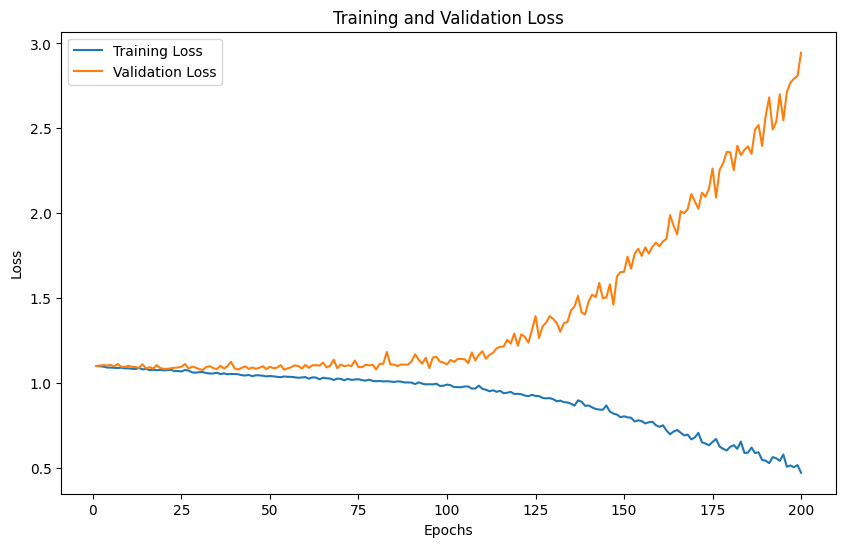

In [46]:
# 提取训练损失和验证损失
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 获取训练周期数
epochs = range(1, len(train_loss) + 1)

# 绘制训练损失和验证损失的曲线
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
# 对测试集进行预测
y_pred = model.predict(X_test_scaled)

8/8 [==============================] - 0s 1ms/step


In [48]:
y_test_labels = np.argmax(y_test,axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
print(y_pred.shape)
print(y_pred.dtype)

(232, 3)
float32


In [49]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 90.95%


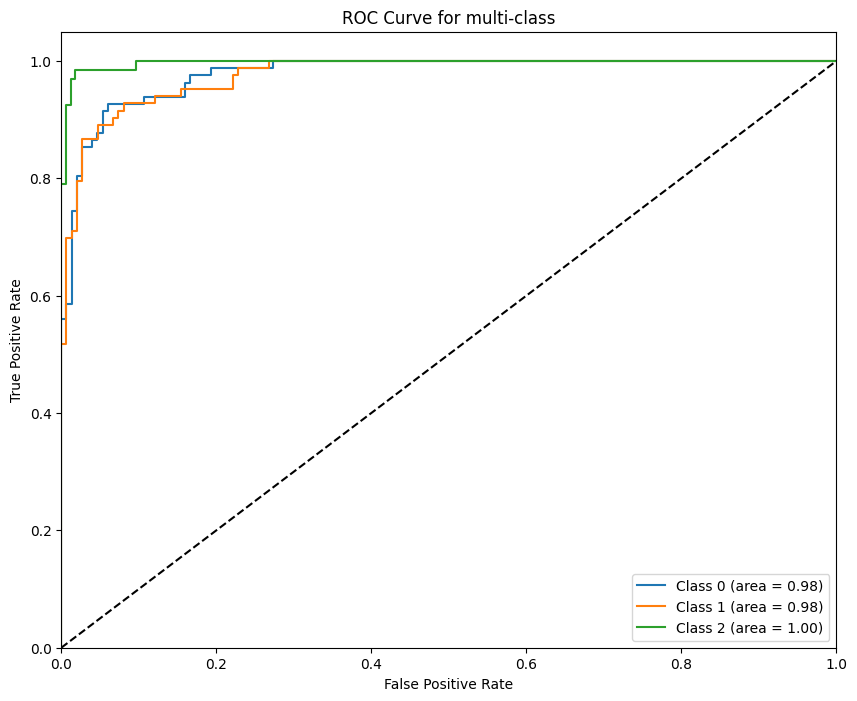

In [50]:
def plot_multiclass_roc(y_test, y_score, n_classes):
    # 计算每个类别的ROC曲线和AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 绘制所有类别的ROC曲线
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
        
   
    # 在函数内部添加数据验证
    if not (y_test.shape[1] == n_classes and y_score.shape[1] == n_classes):
        raise ValueError("y_test and y_score should have the same number of columns as n_classes")

    if np.any(np.isnan(y_test)) or np.any(np.isnan(y_score)):
        raise ValueError("y_test and y_score should not contain NaNs")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for multi-class')
    plt.legend(loc="lower right")
    plt.show()

# 假设y_test1是one-hot编码的标签，y_pred是模型预测的概率输出
plot_multiclass_roc(y_test, y_pred, n_classes=3)

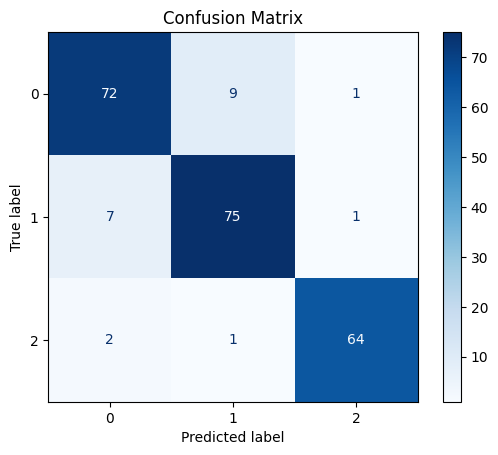

In [51]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# 使用你之前计算的y_test_labels和y_pred_labels
plot_confusion_matrix(y_test_labels, y_pred_labels)